### EDA analysis for cell viability

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from src.auxiliar_functions import AuxFunctions
import numpy as np
import math
import string
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Global style (paper-friendly)
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.linewidth": 1.0,
})

- Reading raw data

In [4]:
df_cell_viability = pd.read_excel("../raw_data/Cell Viability.xlsx")
df_cell_viability.head()

,Cell line,Enzyme,Treatment (%),Cell viability (% of control)
0,RQ,ASNase,0,100.000000
1,RQ,ASNase,0,100.000000
2,RQ,ASNase,0,100.000000
3,RQ,ASNase,50,102.024291
4,RQ,ASNase,50,129.554656


- Making preparation for ploting

In [5]:
df_to_process = df_cell_viability.copy()
df_to_process["Enzyme"] = df_to_process["Enzyme"].astype(str).str.strip()
df_to_process["Treatment (%)"] = pd.to_numeric(df_to_process["Treatment (%)"], errors="coerce")
df_to_process["Cell viability (% of control)"] = pd.to_numeric(df_to_process["Cell viability (% of control)"], errors="coerce")
df_to_process = df_to_process.dropna(subset=["Cell line", "Enzyme", "Treatment (%)", "Cell viability (% of control)"])
df_to_process

,Cell line,Enzyme,Treatment (%),Cell viability (% of control)
0,RQ,ASNase,0,100.000000
1,RQ,ASNase,0,100.000000
2,RQ,ASNase,0,100.000000
3,RQ,ASNase,50,102.024291
4,RQ,ASNase,50,129.554656
...,...,...,...,...
175,MCF-7,ADI,70,80.126582
176,MCF-7,ADI,70,78.227848
177,MCF-7,ADI,90,48.536210
178,MCF-7,ADI,90,40.446841


In [6]:
# Canonical order for treatments
treat_order = [0, 50, 70, 90]
present_treats = [t for t in treat_order if t in set(df_to_process["Treatment (%)"].unique())]
if len(present_treats) < 2:
    raise ValueError("Not enough distinct treatment levels found.")

In [7]:
df_to_process["Treatment (%)"] = pd.Categorical(df_to_process["Treatment (%)"], categories=present_treats, ordered=True)


In [8]:
enzyme_order = [
    "ASNase",
    "ADI",
    "GLNase",
    "GO",
    "SDH"]

present_enzymes = list(df_to_process["Enzyme"].unique())
enzyme_order = [e for e in enzyme_order if e in present_enzymes] + [e for e in present_enzymes if e not in enzyme_order]

In [9]:
summary = (
    df_to_process.groupby(["Enzyme", "Treatment (%)"], as_index=False)
           .agg(
               mean_viability=("Cell viability (% of control)", "mean"),
               sd_viability=("Cell viability (% of control)", "std"),
               n=("Cell viability (% of control)", "size"),
           )
           .sort_values(["Enzyme", "Treatment (%)"])
)

summary.head()

,Enzyme,Treatment (%),mean_viability,sd_viability,n
0,ADI,0,100.000000,0.000000,9
1,ADI,50,108.559109,13.584444,9
2,ADI,70,92.399176,14.723614,9
3,ADI,90,36.688059,5.581021,9
4,ASNase,0,100.000000,0.000000,9


In [10]:
pastel_blue = {
    0:  "#F2F6FB",
    50: "#D6E4F5",
    70: "#9DBCE6",
    90: "#4F81BD",
}

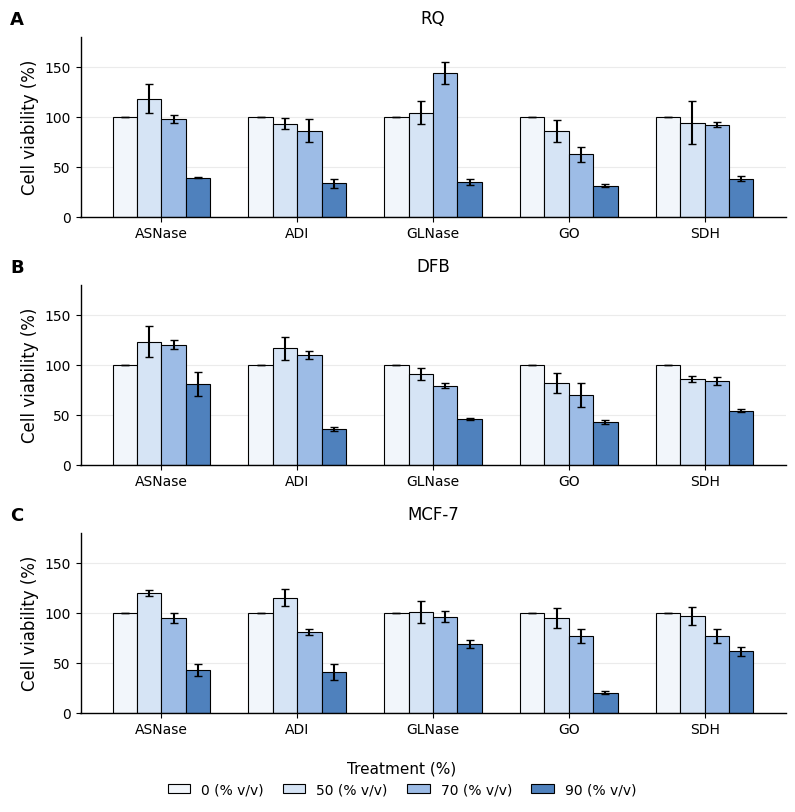

In [11]:
# ============================================================
# Subpanels by Cell line (2 columns), panel letters, legend bottom
# ============================================================

# --- Choose order of cell lines
cell_lines = list(pd.unique(df_to_process["Cell line"]))
# cell_lines = sorted(cell_lines)  # optional

enzyme_order = list(enzyme_order)
x_labels = enzyme_order

treatments = list(df_to_process["Treatment (%)"].cat.categories)
n_groups = len(treatments)

bar_width = 0.18 if n_groups >= 4 else 0.22

# --- Layout: 2 columns (vertical)
n_panels = len(cell_lines)
ncols = 1
nrows = 3

# Figure size tuned for "vertical" layout
fig_w = max(9.5, 1.20 * len(enzyme_order)) * (ncols / 2.0)
fig_h = 4.4 * nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8), sharey=True)
axes = np.array(axes).reshape(-1)

x = np.arange(len(enzyme_order))

for idx, cl in enumerate(cell_lines):
    ax = axes[idx]

    # --- Filter per cell line
    df_cl = df_to_process[df_to_process["Cell line"] == cl].copy()

    # --- Summary per cell line
    summary_cl = (
        df_cl.groupby(["Enzyme", "Treatment (%)"], observed=True)
             .agg(mean_viability=("Cell viability (% of control)", "mean"),
                  sd_viability=("Cell viability (% of control)", "std"))
             .reset_index()
    )

    sum_plot = summary_cl.set_index(["Enzyme", "Treatment (%)"]).reindex(
        pd.MultiIndex.from_product([enzyme_order, treatments],
                                   names=["Enzyme", "Treatment (%)"])
    ).reset_index()

    # --- Bars + error bars
    for i, t in enumerate(treatments):
        t_float = float(t)
        sub = sum_plot[sum_plot["Treatment (%)"] == t].set_index("Enzyme").reindex(enzyme_order)

        means = sub["mean_viability"].values
        sds = sub["sd_viability"].values

        offsets = (i - (n_groups - 1) / 2) * bar_width
        xpos = x + offsets

        ax.bar(
            xpos,
            means,
            width=bar_width,
            yerr=sds,
            capsize=3,
            edgecolor="black",
            linewidth=0.8,
            color=pastel_blue.get(t_float, "#CCCCCC"),
            label=f"{t_float:g} (% v/v)" if idx == 0 else None,  # legend once
            zorder=2
        )

    else:
        letter_map = {}

    if len(letter_map) > 0:
        for i, t in enumerate(treatments):
            t_float = float(t)
            offsets = (i - (n_groups - 1) / 2) * bar_width
            xpos = x + offsets

            sub = sum_plot[sum_plot["Treatment (%)"] == t].set_index("Enzyme").reindex(enzyme_order)
            means = sub["mean_viability"].values
            sds = sub["sd_viability"].values

            for j, enz in enumerate(enzyme_order):
                L = letter_map.get((enz, t_float), "")
                if L == "" or np.isnan(means[j]):
                    continue

                y = means[j] + (0 if np.isnan(sds[j]) else sds[j]) + 4
                ax.text(xpos[j], y, L, ha="center", va="bottom",
                        fontsize=10, fontweight="bold", zorder=3)

    # --- Panel label: A, B, C...
    panel_letter = string.ascii_uppercase[idx]
    ax.text(
        -0.10, 1.05, panel_letter,
        transform=ax.transAxes,
        fontsize=13,
        fontweight="bold",
        va="bottom",
        ha="left"
    )

    # --- Axes formatting
    ax.set_title(str(cl), fontsize=12, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if idx % ncols == 0:
        ax.set_ylabel("Cell viability (%)")
    else:
        ax.set_ylabel("")

# --- Turn off unused axes
for k in range(n_panels, len(axes)):
    axes[k].axis("off")

# --- Shared Y limits with headroom
y_max = df_to_process["Cell viability (% of control)"].max()
fig_ylim = max(120, np.ceil((y_max + 20) / 10) * 10)
for ax in axes[:n_panels]:
    ax.set_ylim(0, fig_ylim)

# --- Legend bottom (global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Treatment (%)",
    frameon=False,
    ncol=min(4, n_groups),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    handlelength=1.6,
    columnspacing=1.4
)

# Leave space at bottom for legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


Figure summarizes the effect of increasing treatment concentration on cell viability across five enzymes and three cell lines (RQ, DFB, and MCF-7). In all cell lines, a clear concentration-dependent reduction in viability is observed for most enzymes, with the strongest effects consistently detected at 90% (v/v). ASNase and ADI exhibit moderate effects at intermediate concentrations (50–70%), while inducing pronounced viability loss at the highest concentration, particularly in RQ and MCF-7 cells. GLNase displays a distinct profile, characterized by an apparent increase in viability at 70% in RQ cells, followed by a sharp decrease at 90%, suggesting a non-linear, cell line–specific response. GO shows the most pronounced cytotoxicity across all three cell lines, with substantial viability reductions already evident at 70% and reaching minimal levels at 90%, especially in MCF-7 cells. In contrast, SDH induces a more gradual decline, indicating comparatively lower cytotoxic potency. Notably, DFB cells appear less sensitive overall, retaining higher viability at intermediate concentrations for most enzymes, whereas MCF-7 cells display the strongest susceptibility, particularly to GO and ASNase. These data indicate that cytotoxic responses are both enzyme-dependent and cell line–specific, with marked heterogeneity in dose–response profiles.

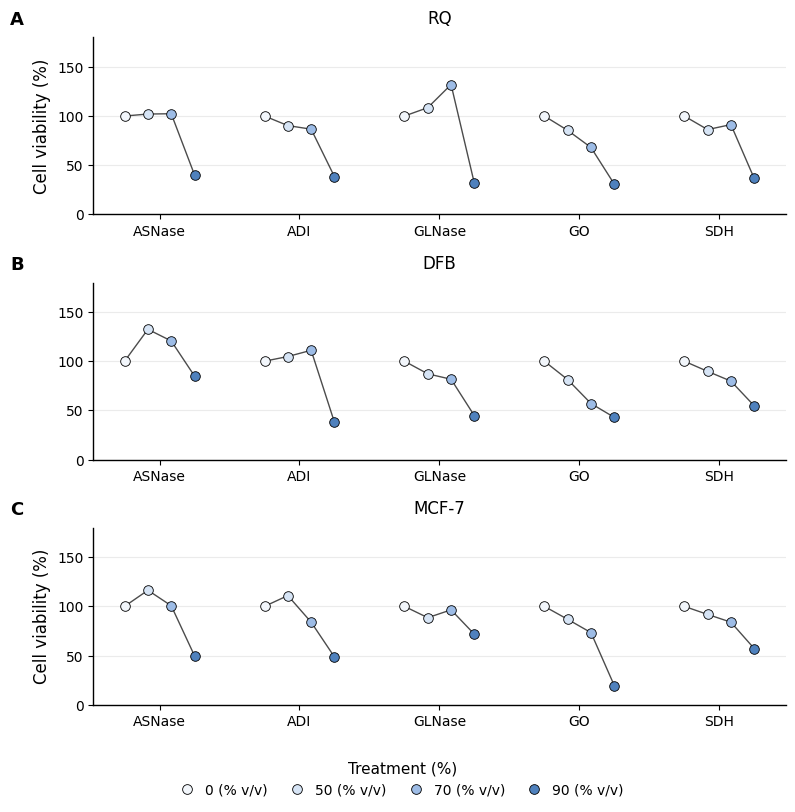

In [12]:
# ============================
# Config
# ============================
value_col = "Cell viability (% of control)"
treat_col = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col = "Cell line"

enzyme_order = list(enzyme_order)  # el que ya usas
cell_lines = list(pd.unique(df_to_process[cell_col]))

# Orden tratamientos
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())

# Paleta (la tuya)
pastel_blue = {
    0:  "#F2F6FB",
    50: "#D6E4F5",
    70: "#9DBCE6",
    90: "#4F81BD",
}
palette = {float(t): pastel_blue.get(float(t), "#CCCCCC") for t in treat_order}

# ============================
# Layout: 2 columnas, vertical
# ============================
n_panels = len(cell_lines)
ncols = 2 if n_panels > 1 else 1
nrows = int(math.ceil(n_panels / ncols))

fig_w = max(9.5, 1.20 * len(enzyme_order)) * (ncols / 2.0)
fig_h = 4.8 * nrows
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharey=True)
axes = np.array(axes).reshape(-1)

x_base = np.arange(len(enzyme_order))

n_treat = len(treat_order)
offsets = np.linspace(-0.25, 0.25, n_treat)

for idx, cl in enumerate(cell_lines):
    ax = axes[idx]
    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()

    panel_letter = string.ascii_uppercase[idx]
    ax.text(-0.12, 1.05, panel_letter, transform=ax.transAxes,
            fontsize=13, fontweight="bold", va="bottom", ha="left")

    ax.set_title(str(cl), fontsize=12, pad=10)

    for i, enz in enumerate(enzyme_order):
        sub = df_cl[df_cl[enzyme_col] == enz].copy()
        if sub.empty:
            continue

        sub[treat_col] = pd.Categorical(sub[treat_col], categories=treat_order, ordered=True)
        sub = sub.sort_values(treat_col)

        xs = []
        ys = []

        for k, t in enumerate(treat_order):
            row = sub[sub[treat_col] == t]
            if row.empty:
                continue

            y = row[value_col].values[0]
            x = x_base[i] + offsets[k]

            # Punto
            ax.scatter(
                x, y,
                s=48,
                color=palette[float(t)],
                edgecolor="black",
                linewidth=0.6,
                zorder=3
            )

            xs.append(x)
            ys.append(y)

        if len(xs) >= 2:
            ax.plot(xs, ys, color="black", linewidth=1.0, alpha=0.7, zorder=2)

    ax.set_xticks(x_base)
    ax.set_xticklabels(enzyme_order, fontsize=10)
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.25, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if idx % ncols == 0:
        ax.set_ylabel("Cell viability (%)")
    else:
        ax.set_ylabel("")

for k in range(n_panels, len(axes)):
    axes[k].axis("off")

y_max = np.nanmax(df_to_process[value_col].values)
fig_ylim = max(120, np.ceil((y_max + 20) / 10) * 10)
for ax in axes[:n_panels]:
    ax.set_ylim(0, fig_ylim)

handles = []
labels = []
for t in treat_order:
    h = plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=7,
        markerfacecolor=palette[float(t)],
        markeredgecolor='black',
        markeredgewidth=0.6
    )
    handles.append(h)
    labels.append(f"{float(t):g} (% v/v)")

fig.legend(
    handles, labels,
    title="Treatment (%)",
    frameon=False,
    ncol=min(4, len(treat_order)),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    handlelength=1.0,
    columnspacing=1.6
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


Figure X depicts the dose–response profiles of cell viability for each enzyme across increasing treatment concentrations (0–90% v/v) in RQ, DFB, and MCF-7 cell lines. Across all panels, a consistent downward trend is observed with increasing concentration, indicating a general concentration-dependent cytotoxic effect. However, the shape and steepness of the response curves vary markedly between enzymes and cell lines, revealing pronounced heterogeneity in sensitivity. In RQ cells, GLNase exhibits a non-monotonic profile, with a transient increase in viability at 70% followed by a sharp decline at 90%, suggesting a non-linear response. GO displays the steepest negative slope in all three cell lines, with rapid viability loss already evident at 70% and near-complete loss at 90% in MCF-7 cells, indicating high cytotoxic potency. In contrast, SDH and ADI show more gradual declines, consistent with lower cytotoxic impact. DFB cells consistently retain higher viability at intermediate concentrations compared to RQ and MCF-7, indicating reduced sensitivity, whereas MCF-7 cells exhibit the most pronounced susceptibility across enzymes. Collectively, these profiles demonstrate that cytotoxic effects are not only dose-dependent but also strongly enzyme- and cell line–specific, with distinct response dynamics across conditions.

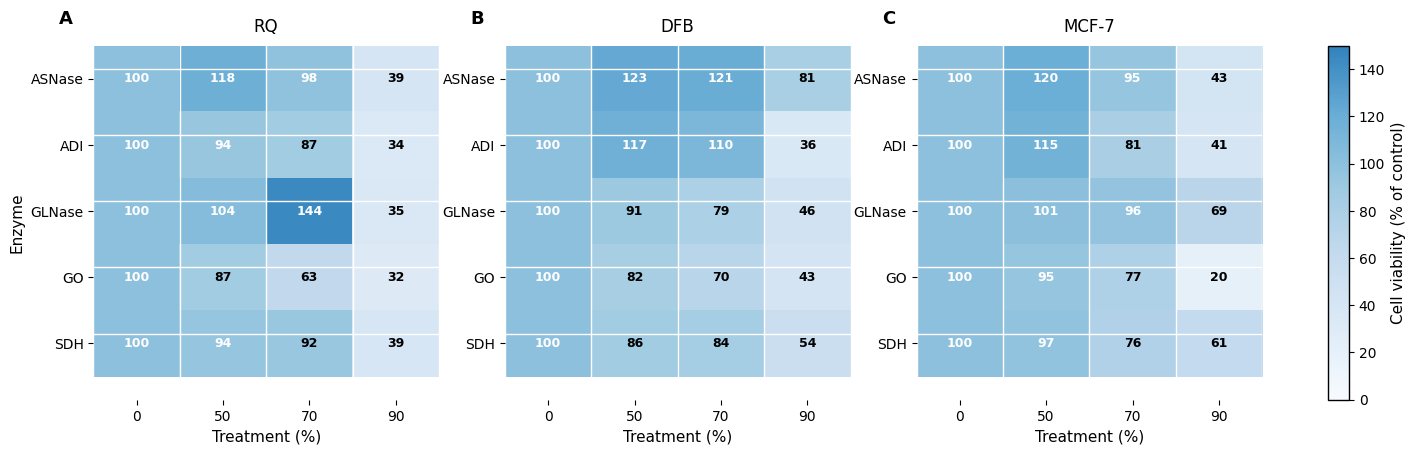

In [13]:
# ============================
# Config
# ============================
value_col = "Cell viability (% of control)"
treat_col = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col = "Cell line"

cell_lines = list(pd.unique(df_to_process[cell_col]))
enzyme_order = list(enzyme_order)

# Orden tratamientos
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())

# ============================
# Build heatmap matrices
# ============================
heatmaps = []
for cl in cell_lines:
    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()
    mat = (df_cl.pivot_table(index=enzyme_col, columns=treat_col, values=value_col, aggfunc="mean")
               .reindex(index=enzyme_order, columns=treat_order))
    heatmaps.append(mat)

# Global scaling (comparables)
global_min = np.nanmin([m.values for m in heatmaps])
global_max = np.nanmax([m.values for m in heatmaps])

# Ajusta esto si quieres forzar rango fijo (ej 0-120 o 0-150)
vmin = 0
vmax = max(120, np.ceil((global_max + 5) / 10) * 10)

# ============================
# Pastel colormap (custom)
# ============================
pastel_colors = ["#F7FBFF", "#DEEBF7", "#C6DBEF", "#9ECAE1", "#6BAED6", "#3182BD"]
cmap = LinearSegmentedColormap.from_list("pastel_blues", pastel_colors)

# ============================
# Figure layout: 1x3 + dedicated colorbar axis
# ============================
fig = plt.figure(figsize=(16.2, 4.6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.06], wspace=0.25)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

# Shared norm for consistent colors across panels
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# ============================
# Plot
# ============================
for i, (ax, cl, mat) in enumerate(zip(axes, cell_lines, heatmaps)):
    data = mat.values

    im = ax.imshow(data, aspect="auto", cmap=cmap, norm=norm)

    # Panel label A/B/C
    ax.text(-0.10, 1.05, string.ascii_uppercase[i],
            transform=ax.transAxes, fontsize=13, fontweight="bold",
            va="bottom", ha="left")

    ax.set_title(str(cl), fontsize=12, pad=10)

    # Axis ticks/labels
    ax.set_xticks(np.arange(len(treat_order)))
    ax.set_xticklabels([f"{float(t):g}" for t in treat_order], fontsize=10)
    ax.set_xlabel("Treatment (%)", fontsize=11)

    ax.set_yticks(np.arange(len(enzyme_order)))
    # para que se vean las enzimas: muéstralas en TODOS los paneles
    ax.set_yticklabels(enzyme_order, fontsize=10)
    if i == 0:
        ax.set_ylabel("Enzyme", fontsize=11)

    # Subtle cell borders (paper style)
    ax.set_xticks(np.arange(-.5, len(treat_order), 1), minor=True)
    ax.set_yticks(np.arange(-.15, len(enzyme_order), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Remove spines
    for sp in ax.spines.values():
        sp.set_visible(False)

    # ============================
    # Annotate values in each cell
    # ============================
    # Texto negro/blanco dependiendo del fondo
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            val = data[r, c]
            if np.isnan(val):
                continue

            # Contraste simple: si está alto, texto más oscuro o blanco
            # (umbral relativo)
            txt_color = "black" if (val < (vmin + 0.62*(vmax - vmin))) else "white"

            ax.text(
                c, r, f"{val:.0f}",
                ha="center", va="center",
                fontsize=9, color=txt_color, fontweight="bold"
            )

# ============================
# Colorbar (no overlap)
# ============================
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cb.set_label("Cell viability (% of control)", fontsize=11)
cb.ax.tick_params(labelsize=10)

plt.show()


Figure X provides a global overview of cell viability patterns across enzymes, treatment concentrations, and cell lines. The heatmaps reveal a clear concentration-dependent shift from high to low viability across all cell lines, with the strongest reductions consistently observed at 90% (v/v). However, the magnitude and progression of these effects differ substantially between enzymes and cell lines. In RQ cells, GLNase displays an atypical profile, with a marked increase in viability at 70% followed by a sharp collapse at 90%, highlighting a non-linear and cell line–specific response. In contrast, GO exhibits uniformly low viability at 90% across all three cell lines, reaching minimal levels in MCF-7 cells, indicating strong and consistent cytotoxicity. DFB cells generally retain higher viability at intermediate concentrations (50–70%) for most enzymes, suggesting reduced sensitivity, whereas MCF-7 cells show pronounced susceptibility, particularly to GO and ASNase. SDH and ADI demonstrate more moderate and gradual declines across concentrations, consistent with lower cytotoxic potency. Overall, the heatmaps underscore substantial heterogeneity in cytotoxic profiles, driven by both enzyme identity and cellular context, and reveal distinct response patterns that are not readily apparent from single-condition comparisons.

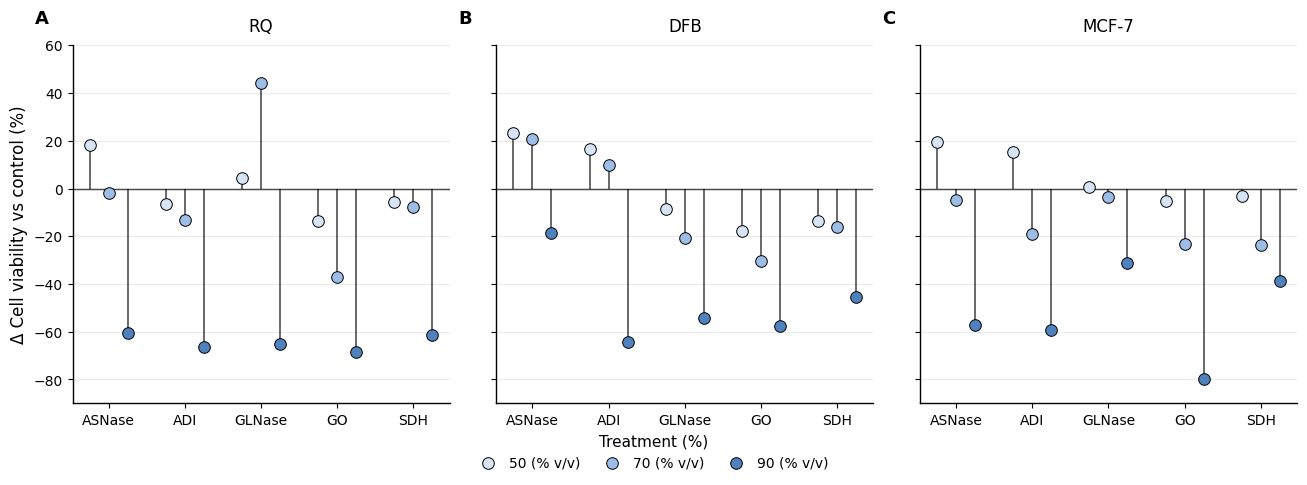

In [14]:
# ============================
# Config
# ============================
value_col = "Cell viability (% of control)"
treat_col  = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col   = "Cell line"

enzyme_order = list(enzyme_order)
cell_lines = list(pd.unique(df_to_process[cell_col]))

# Orden tratamientos
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())

# Paleta
pastel_blue = {
    0:  "#F2F6FB",
    50: "#D6E4F5",
    70: "#9DBCE6",
    90: "#4F81BD",
}
palette = {float(t): pastel_blue.get(float(t), "#CCCCCC") for t in treat_order}

# ============================
# Δ vs control
# ============================
wide = (df_to_process
        .pivot_table(index=[cell_col, enzyme_col],
                     columns=treat_col,
                     values=value_col,
                     aggfunc="mean")
        .reindex(columns=treat_order))

t0 = treat_order[0]  # assumed 0
delta = wide.subtract(wide[t0], axis=0)

delta_long = (delta.reset_index()
                   .melt(id_vars=[cell_col, enzyme_col],
                         var_name=treat_col,
                         value_name="Delta"))

# Excluye control (Δ=0 trivial)
delta_long = delta_long[delta_long[treat_col] != t0].copy()
delta_long[treat_col] = pd.Categorical(delta_long[treat_col], categories=treat_order, ordered=True)

treat_no0 = [t for t in treat_order if t != t0]

# ============================
# Plot: 1×3
# ============================
n_panels = len(cell_lines)
fig_w = 4.4 * n_panels
fig_h = 4.8
fig, axes = plt.subplots(1, n_panels, figsize=(fig_w, fig_h), sharey=True)
if n_panels == 1:
    axes = [axes]

x = np.arange(len(enzyme_order))

# Offsets por tratamiento para separar lollipops
n_groups = len(treat_no0)
offsets = np.linspace(-0.25, 0.25, n_groups)

for i, (ax, cl) in enumerate(zip(axes, cell_lines)):
    # Panel label A/B/C
    ax.text(-0.10, 1.05, string.ascii_uppercase[i],
            transform=ax.transAxes, fontsize=13, fontweight="bold",
            va="bottom", ha="left")

    ax.set_title(str(cl), fontsize=12, pad=10)

    df_cl = delta_long[delta_long[cell_col] == cl].copy()

    # Baseline at 0
    ax.axhline(0, linewidth=1.0, color="black", alpha=0.85, zorder=1)

    for k, t in enumerate(treat_no0):
        sub = (df_cl[df_cl[treat_col] == t]
               .set_index(enzyme_col)
               .reindex(enzyme_order))

        vals = sub["Delta"].values
        xpos = x + offsets[k]

        # Stems (lollipop sticks)
        ax.vlines(
            xpos,
            0,
            vals,
            color="black",
            linewidth=1.1,
            alpha=0.75,
            zorder=2
        )

        # Heads (dots)
        ax.scatter(
            xpos,
            vals,
            s=70,
            color=palette[float(t)],
            edgecolor="black",
            linewidth=0.7,
            zorder=3,
            label=f"{float(t):g} (% v/v)" if i == 0 else None
        )

    # Axes formatting
    ax.set_xticks(x)
    ax.set_xticklabels(enzyme_order, fontsize=10)
    ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("")

    if i == 0:
        ax.set_ylabel("Δ Cell viability vs control (%)")
    else:
        ax.set_ylabel("")

# Global y-limits with headroom
ymin = np.nanmin(delta_long["Delta"].values)
ymax = np.nanmax(delta_long["Delta"].values)
pad = 10
ylim_lo = np.floor((ymin - pad) / 10) * 10
ylim_hi = np.ceil((ymax + pad) / 10) * 10
for ax in axes:
    ax.set_ylim(ylim_lo, ylim_hi)

# Legend bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Treatment (%)",
    frameon=False,
    ncol=min(3, len(treat_no0)),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    handlelength=1.4,
    columnspacing=1.6
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


Figure X illustrates the magnitude and direction of treatment effects relative to the untreated control (Δ cell viability) across enzymes and cell lines. This representation highlights substantial heterogeneity in both the strength and polarity of responses. In RQ cells, most enzymes induce pronounced negative effects at 90% (v/v), with GO and ADI showing the largest reductions, indicating strong cytotoxic impact. Notably, GLNase exhibits a positive deviation at 70% followed by a sharp negative shift at 90%, reinforcing the presence of a non-linear response pattern. In DFB cells, effect sizes are generally attenuated, with several enzymes showing modest positive or near-neutral changes at intermediate concentrations, consistent with reduced sensitivity. In contrast, MCF-7 cells display the largest negative effect sizes, particularly for GO and ASNase, where viability drops dramatically relative to control. Across all cell lines, SDH and ADI tend to produce smaller absolute effect sizes, suggesting comparatively lower cytotoxic potency. Overall, the lollipop profiles emphasize that cytotoxic effects are not only concentration-dependent but also highly enzyme- and cell line–specific, with marked differences in effect magnitude that are not apparent from absolute viability values alone.

- Plotting full panel figure for paper

In [15]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import string
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

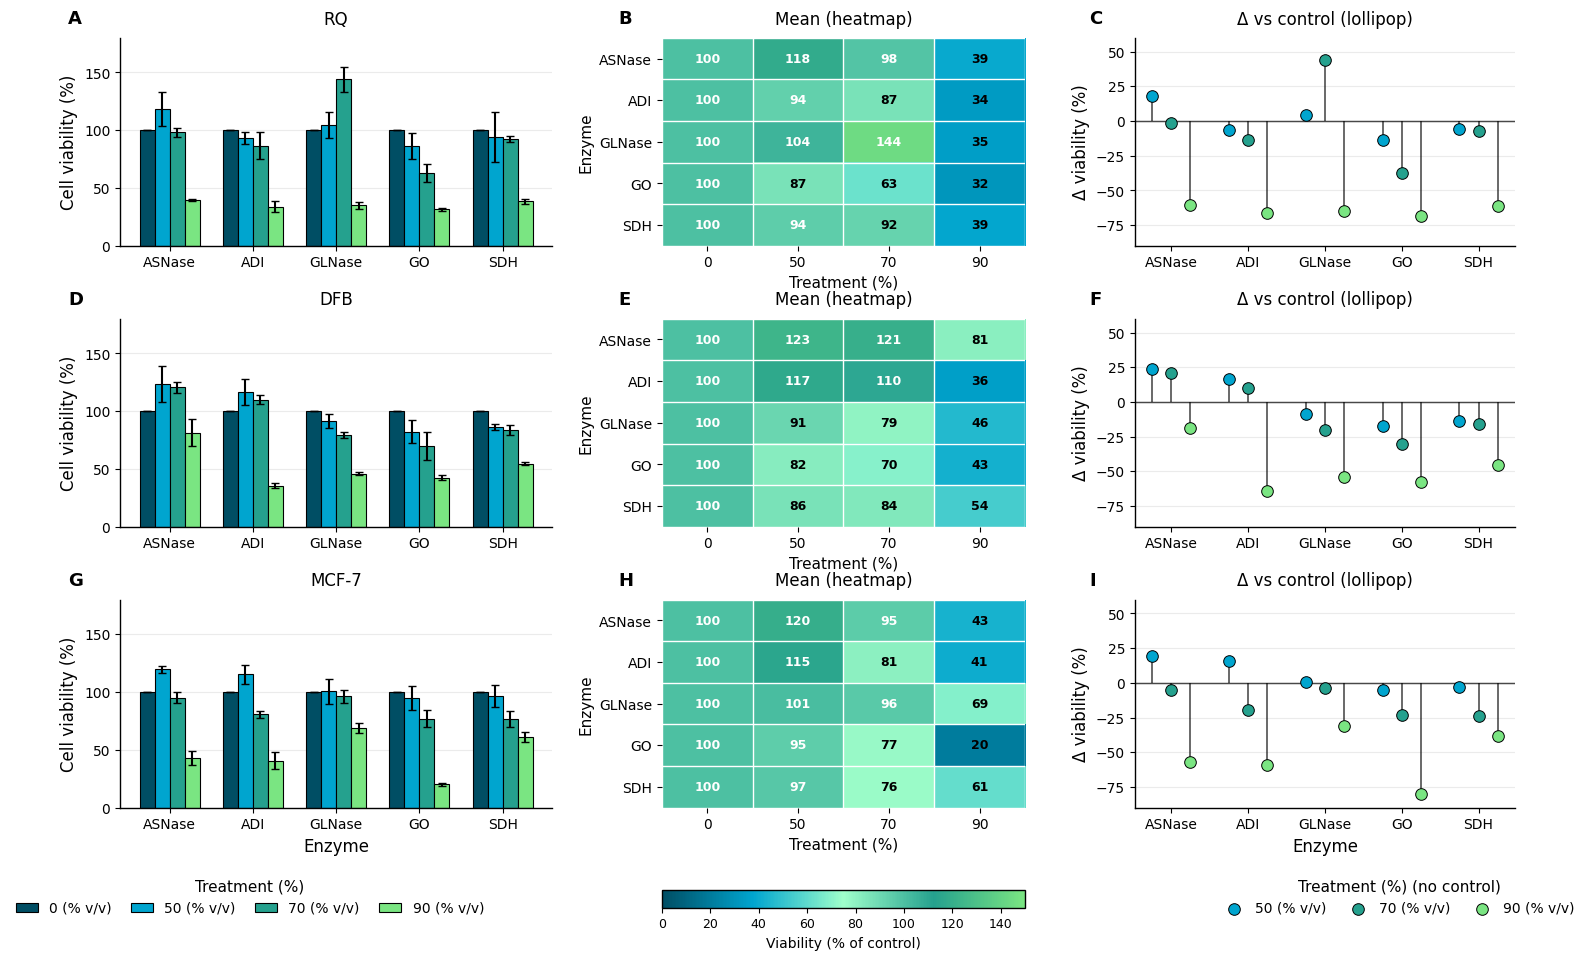

In [28]:
# PALETTE_LIST = ["#2f6690","#3a7ca5","#d9dcd6","#16425b","#81c3d7"]  # <-- cambia aquí
# PALETTE_LIST = ["#ccdbdc","#9ad1d4","#80ced7","#007ea7","#003249"]
PALETTE_LIST = ["#004e64", "#00a5cf", "#9fffcb", "#25a18e", "#7ae582"]

cmap = LinearSegmentedColormap.from_list("custom_palette", PALETTE_LIST)

# Para tratamientos (bars + lollipops): toma tonos distribuidos desde la paleta
def sample_palette(colors, n):
    if n <= 1:
        return [colors[0]]
    idx = np.linspace(0, len(colors) - 1, n).round().astype(int)
    return [colors[i] for i in idx]

value_col = "Cell viability (% of control)"
treat_col = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col  = "Cell line"

cell_lines   = list(pd.unique(df_to_process[cell_col]))
enzyme_order = list(enzyme_order)

# treatment order
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())
treat_order = list(treat_order)
t0 = treat_order[0]  # control

# colores por tratamiento (barras + lollipop)
treat_colors = sample_palette(PALETTE_LIST, len(treat_order))
palette = {float(t): treat_colors[i] for i, t in enumerate(treat_order)}

# ============================================================
# Precompute heatmaps + global scaling
# ============================================================
heatmaps = []
for cl in cell_lines:
    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()
    mat = (df_cl.pivot_table(index=enzyme_col, columns=treat_col, values=value_col, aggfunc="mean")
               .reindex(index=enzyme_order, columns=treat_order))
    heatmaps.append(mat)

global_min = np.nanmin([m.values for m in heatmaps])
global_max = np.nanmax([m.values for m in heatmaps])

vmin = 0
vmax = max(120, np.ceil((global_max + 5) / 10) * 10)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
heatmap_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# ============================================================
# Precompute deltas for lollipops (Δ vs control)
# ============================================================
wide = (df_to_process
        .pivot_table(index=[cell_col, enzyme_col], columns=treat_col, values=value_col, aggfunc="mean")
        .reindex(columns=treat_order))
delta = wide.subtract(wide[t0], axis=0)

delta_long = (delta.reset_index()
              .melt(id_vars=[cell_col, enzyme_col], var_name=treat_col, value_name="Delta"))
delta_long = delta_long[delta_long[treat_col] != t0].copy()
delta_long[treat_col] = pd.Categorical(delta_long[treat_col], categories=treat_order, ordered=True)
treat_no0 = [t for t in treat_order if t != t0]

# ============================================================
# Figure layout (3×3)
# ============================================================
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(
    nrows=len(cell_lines), ncols=3,
    width_ratios=[1.25, 1.05, 1.10],
    wspace=0.28, hspace=0.35
)

panel_letters = list(string.ascii_uppercase)

# Global y-limits
y_max = np.nanmax(df_to_process[value_col].values)
bar_ylim = max(120, np.ceil((y_max + 20) / 10) * 10)

ymin = np.nanmin(delta_long["Delta"].values)
ymax = np.nanmax(delta_long["Delta"].values)
pad = 10
lol_ylim_lo = np.floor((ymin - pad) / 10) * 10
lol_ylim_hi = np.ceil((ymax + pad) / 10) * 10

# Lollipop offsets
x_base = np.arange(len(enzyme_order))
n_lol = len(treat_no0)
lol_offsets = np.linspace(-0.25, 0.25, n_lol) if n_lol > 1 else np.array([0.0])

# Bar settings
x = np.arange(len(enzyme_order))
bar_width = 0.18 if len(treat_order) >= 4 else 0.22
n_groups = len(treat_order)

# Keep heatmap axes for column colorbar placement
heatmap_axes = []

bar_handles = bar_labels = None
lol_handles = lol_labels = None

for r, cl in enumerate(cell_lines):

    # ----------------------------
    # (1) Barplot
    # ----------------------------
    ax_bar = fig.add_subplot(gs[r, 0])

    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()
    summary_cl = (df_cl.groupby([enzyme_col, treat_col], observed=True)
                      .agg(mean_viability=(value_col, "mean"),
                           sd_viability=(value_col, "std"))
                      .reset_index())

    sum_plot = summary_cl.set_index([enzyme_col, treat_col]).reindex(
        pd.MultiIndex.from_product([enzyme_order, treat_order],
                                   names=[enzyme_col, treat_col])
    ).reset_index()

    for i, t in enumerate(treat_order):
        sub = sum_plot[sum_plot[treat_col] == t].set_index(enzyme_col).reindex(enzyme_order)
        means = sub["mean_viability"].values
        sds   = sub["sd_viability"].values

        offsets = (i - (n_groups - 1) / 2) * bar_width
        xpos = x + offsets

        ax_bar.bar(
            xpos, means, width=bar_width,
            yerr=sds, capsize=3,
            edgecolor="black", linewidth=0.8,
            color=palette[float(t)],
            label=f"{float(t):g} (% v/v)" if r == 0 else None,
            zorder=2
        )

    ax_bar.text(-0.12, 1.05, panel_letters[r*3 + 0],
                transform=ax_bar.transAxes, fontsize=13, fontweight="bold",
                va="bottom", ha="left")
    ax_bar.set_title(str(cl), fontsize=12, pad=10)

    ax_bar.set_xticks(x)
    ax_bar.set_xticklabels(enzyme_order, fontsize=10)
    ax_bar.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax_bar.spines["top"].set_visible(False)
    ax_bar.spines["right"].set_visible(False)
    ax_bar.set_ylim(0, bar_ylim)
    ax_bar.set_ylabel("Cell viability (%)")
    ax_bar.set_xlabel("Enzyme" if r == len(cell_lines) - 1 else "")

    if r == 0:
        bar_handles, bar_labels = ax_bar.get_legend_handles_labels()

    # ----------------------------
    # (2) Heatmap
    # ----------------------------
    ax_hm = fig.add_subplot(gs[r, 1])
    heatmap_axes.append(ax_hm)

    mat = heatmaps[r]
    data = mat.values

    im = ax_hm.imshow(data, aspect="auto", cmap=cmap, norm=norm)

    ax_hm.text(-0.12, 1.05, panel_letters[r*3 + 1],
               transform=ax_hm.transAxes, fontsize=13, fontweight="bold",
               va="bottom", ha="left")

    ax_hm.set_title("Mean (heatmap)", fontsize=12, pad=10)
    ax_hm.set_xticks(np.arange(len(treat_order)))
    ax_hm.set_xticklabels([f"{float(t):g}" for t in treat_order], fontsize=10)
    ax_hm.set_xlabel("Treatment (%)", fontsize=11)

    ax_hm.set_yticks(np.arange(len(enzyme_order)))
    ax_hm.set_yticklabels(enzyme_order, fontsize=10)
    ax_hm.set_ylabel("Enzyme", fontsize=11)

    # grid-like separators
    ax_hm.set_xticks(np.arange(-.5, len(treat_order), 1), minor=True)
    ax_hm.set_yticks(np.arange(-.5, len(enzyme_order), 1), minor=True)
    ax_hm.grid(which="minor", color="white", linestyle="-", linewidth=1.0)
    ax_hm.tick_params(which="minor", bottom=False, left=False)
    for sp in ax_hm.spines.values():
        sp.set_visible(False)

    # annotate values
    for rr in range(data.shape[0]):
        for cc in range(data.shape[1]):
            val = data[rr, cc]
            if np.isnan(val):
                continue
            txt_color = "black" if (val < (vmin + 0.62*(vmax - vmin))) else "white"
            ax_hm.text(cc, rr, f"{val:.0f}",
                       ha="center", va="center",
                       fontsize=9, color=txt_color, fontweight="bold")

    # ----------------------------
    # (3) Lollipop (Δ vs control)
    # ----------------------------
    ax_lol = fig.add_subplot(gs[r, 2])

    ax_lol.text(-0.12, 1.05, panel_letters[r*3 + 2],
                transform=ax_lol.transAxes, fontsize=13, fontweight="bold",
                va="bottom", ha="left")
    ax_lol.set_title("Δ vs control (lollipop)", fontsize=12, pad=10)

    df_lcl = delta_long[delta_long[cell_col] == cl].copy()
    ax_lol.axhline(0, linewidth=1.0, color="black", alpha=0.85, zorder=1)

    for k, t in enumerate(treat_no0):
        sub = (df_lcl[df_lcl[treat_col] == t]
               .set_index(enzyme_col)
               .reindex(enzyme_order))
        vals = sub["Delta"].values
        xpos = x_base + lol_offsets[k]

        ax_lol.vlines(xpos, 0, vals, color="black", linewidth=1.1, alpha=0.75, zorder=2)
        ax_lol.scatter(
            xpos, vals, s=70,
            color=palette[float(t)], edgecolor="black", linewidth=0.7, zorder=3,
            label=f"{float(t):g} (% v/v)" if r == 0 else None
        )

    ax_lol.set_xticks(x_base)
    ax_lol.set_xticklabels(enzyme_order, fontsize=10)
    ax_lol.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax_lol.spines["top"].set_visible(False)
    ax_lol.spines["right"].set_visible(False)
    ax_lol.set_ylim(lol_ylim_lo, lol_ylim_hi)
    ax_lol.set_ylabel("Δ viability (%)")
    ax_lol.set_xlabel("Enzyme" if r == len(cell_lines) - 1 else "")

    if r == 0:
        lol_handles, lol_labels = ax_lol.get_legend_handles_labels()

# ============================================================
# Colorbar al FINAL de la columna de heatmaps (una sola)
# ============================================================
# Calcula el bounding box que cubre TODOS los heatmaps (en coords de figura)
bboxes = [ax.get_position() for ax in heatmap_axes]
x0 = min(bb.x0 for bb in bboxes)
y0 = min(bb.y0 for bb in bboxes)
x1 = max(bb.x1 for bb in bboxes)
y1 = max(bb.y1 for bb in bboxes)

# Crea un eje angosto justo a la derecha de la columna 2
pad = 0.012
cbar_w = 0.012
# cax = fig.add_axes([x1 + pad, y0, cbar_w, y1 - y0])

# cb = fig.colorbar(heatmap_mappable, cax=cax)
# ============================================================
# Colorbar HORIZONTAL al final de la columna de heatmaps (una sola)
# ============================================================
bboxes = [ax.get_position() for ax in heatmap_axes]
x0 = min(bb.x0 for bb in bboxes)
y0 = min(bb.y0 for bb in bboxes)
x1 = max(bb.x1 for bb in bboxes)
y1 = max(bb.y1 for bb in bboxes)

# Barra horizontal debajo de la columna 2
pad = 0.1      # separación vertical respecto a los heatmaps
cbar_h = 0.018  # altura de la barra (en coords de figura)

cax = fig.add_axes([x0, y0 - pad, (x1 - x0), cbar_h])  # [left, bottom, width, height]
cb = fig.colorbar(heatmap_mappable, cax=cax, orientation="horizontal")

cb.set_label("Viability (% of control)", fontsize=10)
cb.ax.tick_params(labelsize=9)

# ============================================================
# Global legends
# ============================================================
if bar_handles and bar_labels:
    fig.legend(
        bar_handles, bar_labels,
        title="Treatment (%)",
        frameon=False,
        ncol=min(4, len(treat_order)),
        loc="lower left",
        bbox_to_anchor=(0.06, -0.01),
        handlelength=1.6,
        columnspacing=1.4
    )

if lol_handles and lol_labels:
    fig.legend(
        lol_handles, lol_labels,
        title="Treatment (%) (no control)",
        frameon=False,
        ncol=min(3, len(treat_no0)),
        loc="lower right",
        bbox_to_anchor=(0.94, -0.01),
        handlelength=1.4,
        columnspacing=1.6
    )

plt.tight_layout(rect=[0, 0.06, 1, 1])

fig.savefig(
    "../figures_paper/figure_viability_panels.png",
    dpi=600,
    bbox_inches="tight",
    facecolor="white"
)

fig.savefig(
    "../figures_paper/figure_viability_panels.pdf",
    bbox_inches="tight"
)

plt.show()
